In [39]:
ROOT = '/Users/longhoang/Developer/table-recognition/data/SciTSR-partition'

In [40]:
import os
import cv2 as cv
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from typing import List
import copy

from data_utils.utils import *
from merge.heuristics import *
from evaluation.relation import Relation

### Loading Split ground truths

In [41]:
train_dir = os.path.join(ROOT, 'train')
val_dir = os.path.join(ROOT, 'val')

train_label_path = os.path.join(train_dir, 'label')
val_label_path = os.path.join(val_dir, 'label')

train_split_labels = load_json(os.path.join(train_label_path, 'split_label.json'))
val_split_labels = load_json(os.path.join(val_label_path, 'split_label.json'))

len(train_split_labels), len(val_split_labels)

(10000, 1971)

### Calculating the adjacency relation F1

We try to calculate on a single image first

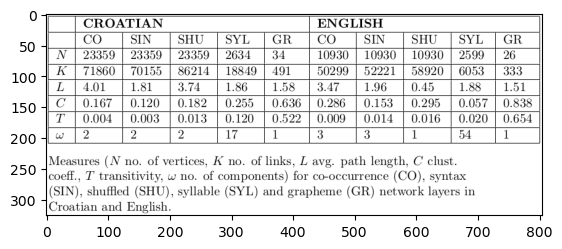

In [42]:
IDX = 32

img_names = list(train_split_labels.keys())
# img_name = img_names[IDX]
img_name = '1507.08539v1.1'

img_path = os.path.join(train_dir, 'img', img_name + '.png')
img = load_image(img_path)
plt.imshow(img)

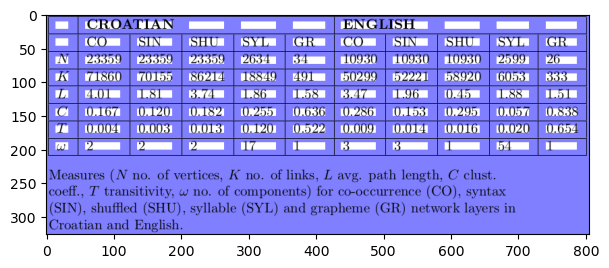

In [43]:
train_merge_labels = load_json(os.path.join(train_label_path, 'merge_label.json'))
val_merge_labels = load_json(os.path.join(val_label_path, 'merge_label.json'))

r_gt, c_gt, R_gt, D_gt = load_merge_gt(train_merge_labels, img_name)
vis_split(img, r_gt, c_gt);

In [44]:
row_gt_idxs, col_gt_idxs = borders(r_gt), borders(c_gt)
cells_gt = get_cells(row_gt_idxs, col_gt_idxs)

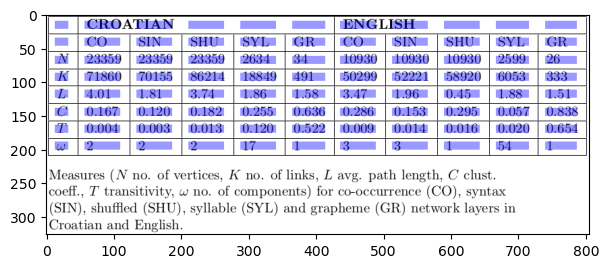

In [45]:
img_boxes = img.copy()
for cell in cells_gt:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (0, 0, 255), -1)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

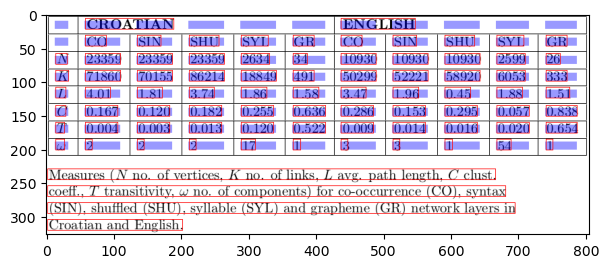

In [46]:
train_chunk_labels = load_json(os.path.join(train_label_path, 'chunk_label.json'))
val_chunk_labels  = load_json(os.path.join(val_label_path, 'chunk_label.json'))

img2 = res.copy()

for text, (l, t, r, b) in train_chunk_labels[img_name]:
    cv.rectangle(img2, (l, t), (r, b), (255, 0, 0), 1)

view_imgs([img2])

In [47]:
cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt, verbose=True)

Merge right at cell (0,9)
Merge right at cell (0,8)
Merge right at cell (0,7)
Merge right at cell (0,6)
Merge right at cell (0,4)
Merge right at cell (0,3)
Merge right at cell (0,2)
Merge right at cell (0,1)


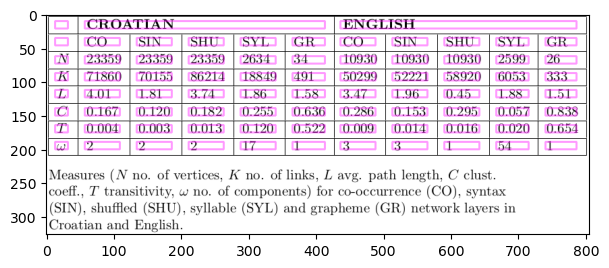

In [48]:
img_boxes = img.copy()
for cell in cells_merged_gt:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (255, 0, 255), 2)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

In [49]:
texts_pos = train_chunk_labels[img_name]
R_pred, D_pred = create_pred_matrices(row_gt_idxs, col_gt_idxs)
rule1(cells_gt, texts_pos, R_pred, D_pred)
rule2(cells_gt, texts_pos, R_pred, D_pred)
cells_merged_pred = merge_cells(cells_gt, R_pred, D_pred, verbose=True)

Merge right at cell (0,7)
Merge right at cell (0,6)
Merge right at cell (0,2)
Merge right at cell (0,1)


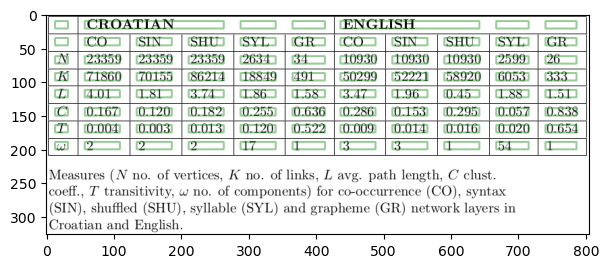

In [50]:
img_boxes = img.copy()
for cell in cells_merged_pred:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (0, 127, 0), 2)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

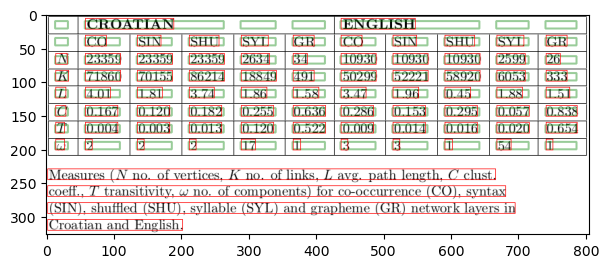

In [51]:
for text, (l, t, r, b) in train_chunk_labels[img_name]:
    cv.rectangle(res, (l, t), (r, b), (255, 0, 0), 1)
view_imgs([res])

In [52]:
len(cells_merged_gt), len(cells_merged_pred)

(80, 84)

Given information:
- List of posistions of ground truth cells (t,l,r,b) in `cells_merged_gt`
- List of positions of predicted cells (t,l,r,b) in `cells_merged_pred`
- List of contents and positions for text (content, (t,l,r,b)) in `texts_pos`

In [53]:
def update_cells_content(cells, texts_pos):
    '''
    Update contents of cells based on positions of texts
    Args:
        cells -- list of Cells
        texts_pos -- contents and positions of texts
    Returns:
        cells -- a deep copy of cells containing texts information
    '''
    cells = copy.deepcopy(cells)
    for cell in cells:
        cell_t, cell_l, cell_b, cell_r = cell.top, cell.left, cell.bottom, cell.right
        for content, (text_l, text_t, text_r, text_b) in texts_pos:
            if (text_l >= cell_l or cell_l - text_l <= 10) and \
                (text_t >= cell_t or cell_t - text_t <= 10) and \
                (text_r <= cell_r or text_r - cell_r <= 10) and \
                (text_b <= cell_b or text_b - cell_b <= 10):
                cell.content = content
    return cells

cells_merged_gt = update_cells_content(cells_merged_gt, texts_pos)
cells_merged_pred = update_cells_content(cells_merged_pred, texts_pos)

In [54]:
cells_merged_pred

[t=10, l=13, b=21, r=32,
 t=10, l=57, b=21, r=263, content='CROATIAN',
 t=10, l=288, b=21, r=340,
 t=10, l=365, b=21, r=413,
 t=10, l=436, b=21, r=642, content='ENGLISH',
 t=10, l=667, b=21, r=715,
 t=10, l=740, b=21, r=786,
 t=35, l=13, b=46, r=32,
 t=35, l=57, b=46, r=109, content='CO',
 t=35, l=134, b=46, r=186, content='SIN',
 t=35, l=211, b=46, r=263, content='SHU',
 t=35, l=288, b=46, r=340, content='SYL',
 t=35, l=365, b=46, r=413, content='GR',
 t=35, l=436, b=46, r=488, content='CO',
 t=35, l=513, b=46, r=565, content='SIN',
 t=35, l=590, b=46, r=642, content='SHU',
 t=35, l=667, b=46, r=715, content='SYL',
 t=35, l=740, b=46, r=786, content='GR',
 t=62, l=13, b=73, r=32, content='N',
 t=62, l=57, b=73, r=109, content='23359',
 t=62, l=134, b=73, r=186, content='23359',
 t=62, l=211, b=73, r=263, content='23359',
 t=62, l=288, b=73, r=340, content='2634',
 t=62, l=365, b=73, r=413, content='34',
 t=62, l=436, b=73, r=488, content='10930',
 t=62, l=513, b=73, r=565, content='10

In [55]:
RIGHT = 1
DOWN = 2

def find_right_relations(cell, cells_list, processed_cells=set(), root=None, n_steps=0):
    rels = []
    
    # Check if the cell has already been processed
    if cell in processed_cells:
        return rels
    
    processed_cells.add(cell)  # Mark the cell as processed

    right_neighbor_l = min((c.left for c in cells_list if c.left >= cell.right), default=None)
    candidates = [c for c in cells_list 
                  if (c.left == right_neighbor_l and c.top >= cell.top and c.bottom <= cell.bottom)]

    if root is None:
        root = cell 
    for cand in candidates:
        if cand.content is not None:
            rels.append(Relation(root.content, cand.content, RIGHT, n_blanks=n_steps))
        else:
            # Find the right relations of this candidate with empty content
            empty_relations = find_right_relations(cand, cells_list, processed_cells, root, n_steps+1)
            rels.extend(empty_relations)

    return rels

def find_down_relations(cell, cells_list, processed_cells=set(), root=None, n_steps=0):
    rels = []
    
    # Check if the cell has already been processed
    if cell in processed_cells:
        return rels
    
    processed_cells.add(cell)  # Mark the cell as processed

    down_neighbor_t = min((c.top for c in cells_list if c.top >= cell.bottom), default=None)
    candidates = [c for c in cells_list
                  if (c.top == down_neighbor_t and c.left >= cell.left and c.right <= cell.right)]

    if root is None:
        root = cell
    for cand in candidates:
        if cand.content is not None:
            rels.append(Relation(root.content, cand.content, DOWN, n_blanks=n_steps))
        else:
            # Find the down relations of this candidate with empty content
            empty_relations = find_down_relations(cand, cells_list, processed_cells, root, n_steps+1)
            rels.extend(empty_relations)

    return rels

In [56]:
find_right_relations(cells_merged_pred[1], cells_merged_pred)

[Relation(CROATIAN, ENGLISH, RIGHT, n_blanks=2)]

In [59]:
find_down_relations(cells_merged_pred[1], cells_merged_pred)

[Relation(CROATIAN, CO, DOWN, n_blanks=0),
 Relation(CROATIAN, SIN, DOWN, n_blanks=0),
 Relation(CROATIAN, SHU, DOWN, n_blanks=0)]

In [58]:
# def cells2relations(cells):
#     '''
#     Convert cells into relations
#     Args:
#         cells -- list of Cells containing texts information
#     Returns:
#         rels -- list of Relations
#     '''
#     rels = []
#     for cell1 in cells: # TODO: check cell1 not None
#         for cell2 in cells:
     